## Platonic subspace hypothesis

The Platonic representation hypothesis ([Huh et al., 2024](https://arxiv.org/abs/2405.07987)) proposes that 

> Neural networks, trained with different objectives on different data and modalities, are converging to a shared statistical model of reality in their representation spaces.

The `Concept16K` dataset provided in `AxBench` offers a way to verify this with LLMs. Since we provide a set of performing supervised dictionary learning methods, can we find a mapping between two models trained on different data and even with slightly different model architectures? Concretely, we try to:

> Given the same set subspaces that map to the same set of concepts, we train two separate dictionaries for `Gemma-2-2B` and `Gemma-2-9B`. Can we find a linear transformation between these two set of subspaces?

We note this as **platonic subspace hypothesis (PSH)**. 

*Caveats: Use PCA not UMAP for this, as UMAP is not sensitive to rotation, etc..*

#### Set-ups

In [36]:
import torch, json, random, einops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    AdamW,
    get_linear_schedule_with_warmup
)
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.decomposition import PCA
from plotnine import (
    ggplot, aes, geom_point, facet_wrap, theme_minimal, theme,
    element_rect, element_line, element_blank, element_text,
    scale_color_manual, geom_density, scale_fill_manual
)
from plotnine import *
import plotly.express as px

def load_jsonl(jsonl_path):
    """
    Load data from a JSON lines file.
    """
    jsonl_data = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            jsonl_data += [data]
    return jsonl_data

def get_genre(metadata_entry):
    """
    Returns the genre string ('text', 'code', or 'math').
    """
    concept_name = metadata_entry['concept']
    return metadata_entry['concept_genres_map'][concept_name][0]

class WeightDataset(Dataset):
    def __init__(self, src_weights, tgt_weights):
        self.src = src_weights
        self.tgt = tgt_weights
    def __len__(self):
        return self.src.shape[0]
    def __getitem__(self, idx):
        return self.src[idx].float(), self.tgt[idx].float()

class AffineTransformation(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AffineTransformation, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        x = self.linear(x)
        return F.normalize(x, p=2, dim=-1)

class LinearTransformation(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearTransformation, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=False)
    def forward(self, x):
        x = self.linear(x)
        return F.normalize(x, p=2, dim=-1)

class LowRankRotateLayer(torch.nn.Module):
    """A linear transformation with orthogonal initialization."""

    def __init__(self, n, m, init_orth=True):
        super().__init__()
        # n > m
        self.weight = torch.nn.Parameter(torch.empty(n, m), requires_grad=True)
        if init_orth:
            torch.nn.init.orthogonal_(self.weight)

    def forward(self, x):
        return torch.matmul(x.to(self.weight.dtype), self.weight)

class RotationTransformation(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RotationTransformation, self).__init__()
        rotate_layer = LowRankRotateLayer(
            input_dim, output_dim, init_orth=True)
        self.rotate_layer = torch.nn.utils.parametrizations.orthogonal(rotate_layer)
    def forward(self, x):
        x = self.rotate_layer(x)
        return F.normalize(x, p=2, dim=-1).to(x.dtype)

In [43]:
src_model_name = "2b" # we start with subspaces from this model
tgt_model_name = "9b" # and map to this model
layer = "l20"
transformation_cls = AffineTransformation

In [44]:
# load two dicts that are trained against the same set of concepts.
lsreft_tgt = torch.load(f"../results/prod_{tgt_model_name}_l20_concept16k_lsreft/train/LsReFT_weight.pt")
lsreft_tgt_metadata = load_jsonl(f"../results/prod_{tgt_model_name}_l20_concept16k_lsreft/train/metadata.jsonl")

lsreft_src = torch.load(f"../results/prod_{src_model_name}_l20_concept16k_lsreft_crossfit/train/LsReFT_weight.pt")
lsreft_src_metadata = load_jsonl(f"../results/prod_{src_model_name}_l20_concept16k_lsreft_crossfit/train/metadata.jsonl")

for idx, md in enumerate(lsreft_tgt_metadata):
    assert md["concept"] == lsreft_src_metadata[idx]["concept"]

#### Visualization

In [45]:
pca_lsreft_tgt = PCA(n_components=2).fit_transform(lsreft_tgt.float().numpy())
pca_lsreft_src = PCA(n_components=2).fit_transform(lsreft_src.float().numpy())

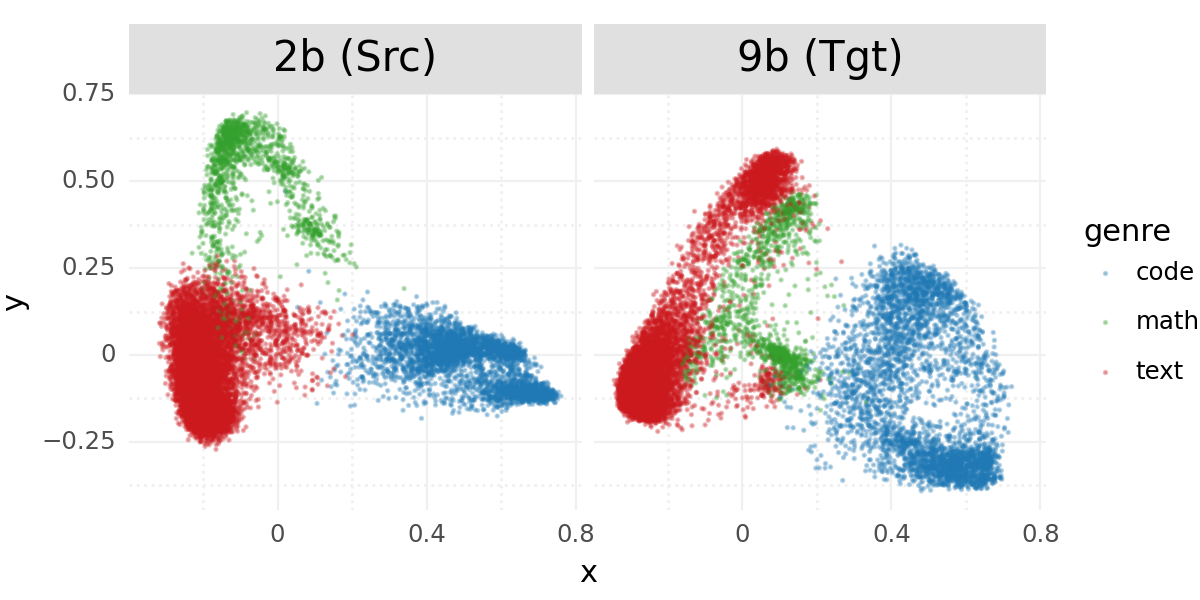

In [46]:
df_lsreft_tgt = pd.DataFrame({
    'x': pca_lsreft_tgt[:, 0],
    'y': pca_lsreft_tgt[:, 1],
    'genre': [get_genre(m) for m in lsreft_tgt_metadata],
    'method': f'{tgt_model_name} (Tgt)'
})
df_lsreft_src = pd.DataFrame({
    'x': pca_lsreft_src[:, 0],
    'y': pca_lsreft_src[:, 1],
    'genre': [get_genre(m) for m in lsreft_src_metadata],
    'method': f'{src_model_name} (Src)'
})
df_all = pd.concat([df_lsreft_tgt, df_lsreft_src], ignore_index=True)

genre_palette = {
    'text': '#CB181D',  # red
    'code': '#1F78B4',  # blue
    'math': '#33A02C',  # green
}

plot = (
    ggplot(df_all, aes('x', 'y', color='genre'))
    + geom_point(size=0.1, alpha=0.3)  # fully opaque
    + facet_wrap('~method')
    + scale_color_manual(values=genre_palette)
    + theme_minimal()
    + theme(
        figure_size=(6, 3),    
        plot_margin=0.0,
        strip_background=element_rect(fill="#E0E0E0", color=None, linewidth=0.00),
        strip_text=element_text(size=15, color="black"),
        panel_border=element_blank(),
        panel_grid_major=element_line(color="#F0F0F0"),
        panel_grid_minor=element_line(color="#F0F0F0", linetype='dotted'),
    )
)

print(plot)

#### Learn a mapping

We will use concepts in `Concept500` as our validation set, so that we can evaluate the mapping just like other methods in `AxBench`.

In [47]:
# filter out concepts in Concept500 for training
concept500 = load_jsonl(f"../concept500/prod_{tgt_model_name}_{layer}_v1/generate/metadata.jsonl")
test_concepts = set([md["concept"] for md in concept500])
selected_idx = set([])
added_concepts = set([])
concept_idx_map = {}
for md_idx, md in enumerate(lsreft_tgt_metadata):
    if md["concept"] not in test_concepts:
        selected_idx.add(md_idx)
    else:
        if md["concept"] not in added_concepts:
            added_concepts.add(md["concept"])
            concept_idx_map[md["concept"]] = md_idx
selected_lsreft_src = [lsreft_src[i] for i in selected_idx]
selected_lsreft_tgt = [lsreft_tgt[i] for i in selected_idx]
selected_lsreft_src = torch.stack(selected_lsreft_src, dim=0)
selected_lsreft_tgt = torch.stack(selected_lsreft_tgt, dim=0)

In [48]:
train_dataset = WeightDataset(selected_lsreft_src, selected_lsreft_tgt)
batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

input_dim = lsreft_src.shape[1]
output_dim = lsreft_tgt.shape[1]
model = transformation_cls(input_dim, output_dim).to("cuda")

In [49]:
criterion = nn.MSELoss(reduction="none")
optimizer = optim.Adam(model.parameters(), lr=8e-3, weight_decay=0.0)

num_epochs = 1000
best_mse = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for src, tgt in train_loader:
        optimizer.zero_grad()
        outputs = model(src.to("cuda"))
        mse_loss = criterion(outputs, tgt.to("cuda")).sum(dim=-1).mean()
        similarity = F.cosine_similarity(outputs, tgt.to("cuda"), dim=-1)
        cos_loss = 1.0 - similarity.mean()
        loss = mse_loss + cos_loss
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * src.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_loss:.6f}")

Epoch 1/1000 - Training Loss: 1.621025
Epoch 101/1000 - Training Loss: 0.383043
Epoch 201/1000 - Training Loss: 0.333401
Epoch 301/1000 - Training Loss: 0.326230
Epoch 401/1000 - Training Loss: 0.324347
Epoch 501/1000 - Training Loss: 0.322818
Epoch 601/1000 - Training Loss: 0.321981
Epoch 701/1000 - Training Loss: 0.322136
Epoch 801/1000 - Training Loss: 0.321801
Epoch 901/1000 - Training Loss: 0.321787


#### Visualize the transformation

In [51]:
lsreft_src_to_tgt = model(lsreft_src.float().to("cuda"))
pca_lsreft_src_to_tgt = PCA(n_components=2).fit_transform(
    lsreft_src_to_tgt.cpu().float().detach().numpy())

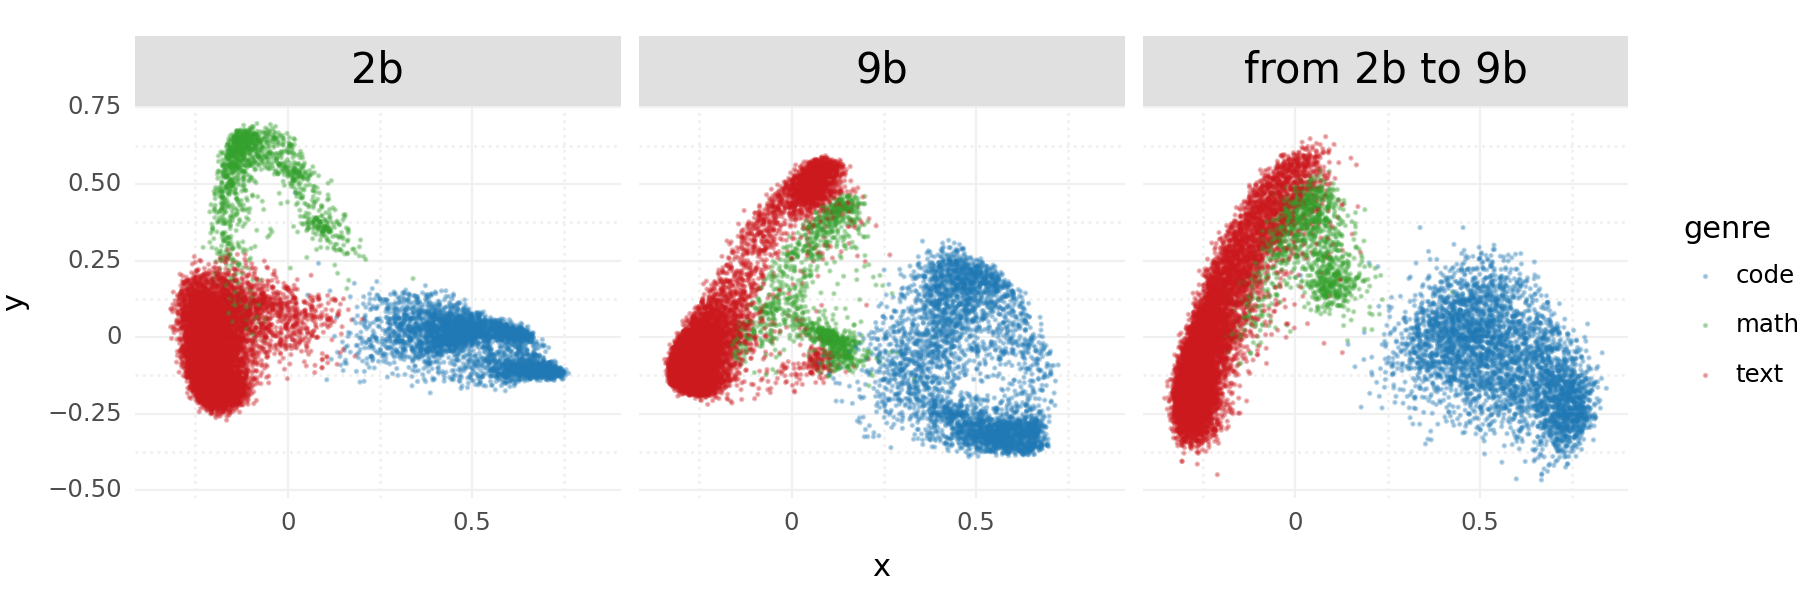

In [52]:
df_lsreft_tgt = pd.DataFrame({
    'x': pca_lsreft_tgt[:, 0],
    'y': pca_lsreft_tgt[:, 1],
    'genre': [get_genre(m) for m in lsreft_tgt_metadata],
    'method': f'{tgt_model_name}'
})
df_lsreft_src = pd.DataFrame({
    'x': pca_lsreft_src[:, 0],
    'y': pca_lsreft_src[:, 1],
    'genre': [get_genre(m) for m in lsreft_src_metadata],
    'method': f'{src_model_name}'
})
df_lsreft_src_to_tgt = pd.DataFrame({
    'x': pca_lsreft_src_to_tgt[:, 0],
    'y': pca_lsreft_src_to_tgt[:, 1],
    'genre': [get_genre(m) for m in lsreft_tgt_metadata],
    'method': f'from {src_model_name} to {tgt_model_name}'
})
df_all = pd.concat([df_lsreft_tgt, df_lsreft_src, df_lsreft_src_to_tgt], ignore_index=True)

genre_palette = {
    'text': '#CB181D',  # red
    'code': '#1F78B4',  # blue
    'math': '#33A02C',  # green
}

plot = (
    ggplot(df_all, aes('x', 'y', color='genre'))
    + geom_point(size=0.1, alpha=0.3)  # fully opaque
    + facet_wrap('~method')
    + scale_color_manual(values=genre_palette)
    + theme_minimal()
    + theme(
        figure_size=(9, 3),    
        plot_margin=0.0,
        strip_background=element_rect(fill="#E0E0E0", color=None, linewidth=0.00),
        strip_text=element_text(size=15, color="black"),
        panel_border=element_blank(),
        panel_grid_major=element_line(color="#F0F0F0"),
        panel_grid_minor=element_line(color="#F0F0F0", linetype='dotted'),
    )
)

print(plot)

**Bonus:** Try to see whther transform from `2b` to `9b` is harder than `9b` to `2b`!

In [ ]:

lambdas = np.linspace(0, 1, num=20)  # 20 frames from 0 to 1
dfs = []

for lambda_val in lambdas:
    pca_transformed = lambda_val*(pca_lsreft_src_to_tgt - pca_lsreft_src) + pca_lsreft_src
    
    # Create DataFrame
    df = pd.DataFrame({
        'x': pca_transformed[:, 0],
        'y': pca_transformed[:, 1],
        'genre': [get_genre(m) for m in lsreft_tgt_metadata],
        'method': f'λ={lambda_val:.2f}'
    })
    dfs.append(df)

# Concatenate all DataFrames and add lambda as a column
df_animation = pd.concat(dfs, ignore_index=True)
df_animation['lambda'] = np.repeat(lambdas, len(lsreft_src))

# Define genre palette
genre_palette = {
    'text': '#CB181D',  # red
    'code': '#1F78B4',  # blue
    'math': '#33A02C',  # green
}

# Create the animation using Plotly
fig = px.scatter(
    df_animation,
    x='x',
    y='y',
    color='genre',
    color_discrete_map=genre_palette,
    animation_frame='lambda',
    title=f'Transformation from {src_model_name} to {tgt_model_name}',
    labels={'x': 'PCA Component 1', 'y': 'PCA Component 2'},
    hover_data={'method': True}
)
fig.update_layout(
    width=500,
    height=500,
    legend_title_text='Genre'
)

fig.show()

#### Evaluate the transformation with AxBench

In [51]:
concept500 = load_jsonl(f"../concept500/prod_{tgt_model_name}_{layer}_v1/generate/metadata.jsonl")
test_lsreft_src = [lsreft_src[concept_idx_map[md["concept"]]] for md in concept500]
test_lsreft_src = torch.stack(test_lsreft_src, dim=0)
test_lsreft_src_to_tgt = model(test_lsreft_src.to("cuda"))
torch.save(test_lsreft_src_to_tgt, f"LsReFT_weight_{tgt_model_name}_{layer}_platonic.pt")